In [1]:
import pennylane as qml
import pennylane.numpy as np
import torch
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam, Adagrad

In [24]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface='torch')
def circuit(phi, theta, data:torch.Tensor):
    qml.AmplitudeEmbedding(data.flatten()[:4], wires=(0, 1), pad_with=0, normalize=True)
    qml.RX(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(theta, wires=0)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.Hadamard(1))

In [25]:
# Test

import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Trouser  Coat  T-shirt/top  Bag


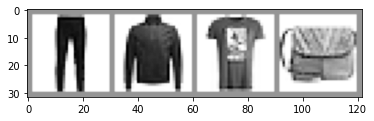

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [84]:
loss_fn = MSELoss()
phi = torch.rand(2, requires_grad=True, dtype=torch.float)
theta = torch.rand(1, requires_grad=True, dtype=torch.float)

optimizer = Adam([phi, theta], lr=0.01)


In [88]:
def cost(phi, theta, data):
    return torch.mean(circuit(phi, theta, data))

for epoch in range(1):
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        loss = torch.tensor(0, dtype=torch.float64)
        for input, label in zip(inputs, labels):
            output = cost(phi, theta, inputs.to(torch.float64))
            loss+=loss_fn(output, label.to(torch.float64))
        loss = loss.float()
        print(loss)
        loss.backward()

        optimizer.step()
        print('{}: {}'.format(i, loss.item()))


tensor(66.0410, grad_fn=<ToCopyBackward0>)
0: 66.04104614257812
tensor(91.3534, grad_fn=<ToCopyBackward0>)
1: 91.35338592529297
tensor(62.0264, grad_fn=<ToCopyBackward0>)
2: 62.02635955810547
tensor(107.6202, grad_fn=<ToCopyBackward0>)
3: 107.62018585205078
tensor(59.3473, grad_fn=<ToCopyBackward0>)
4: 59.347293853759766
tensor(154.4350, grad_fn=<ToCopyBackward0>)
5: 154.43499755859375
tensor(197.0269, grad_fn=<ToCopyBackward0>)
6: 197.02694702148438
tensor(103.5136, grad_fn=<ToCopyBackward0>)
7: 103.51361083984375
tensor(97.1755, grad_fn=<ToCopyBackward0>)
8: 97.17550659179688
tensor(123.0262, grad_fn=<ToCopyBackward0>)
9: 123.02616119384766
tensor(83.0569, grad_fn=<ToCopyBackward0>)
10: 83.05691528320312
tensor(159.5858, grad_fn=<ToCopyBackward0>)
11: 159.58584594726562
tensor(52.7866, grad_fn=<ToCopyBackward0>)
12: 52.786624908447266
tensor(74.7702, grad_fn=<ToCopyBackward0>)
13: 74.77021026611328
tensor(82.2807, grad_fn=<ToCopyBackward0>)
14: 82.28069305419922
tensor(138.8684, grad

KeyboardInterrupt: 

In [19]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = cost(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


TypeError: mean(): argument 'input' (position 1) must be Tensor, not list